# Persistence Forecast for Aare Temperature

_Created by:_ Lewis Tunstall, August 2019

In this notebook we look at forecasting the Aare temperature by simply using past observations to predict future ones. This is called a persistence or naive forecast where

$$ \hat{y}_{t+1} = y_t $$

This model is extremely simple and surprisingly effective, especially when used as a baseline model to compare against more sophisticated techniques. A slightly less naive model is to consider using the $t-2, t-3, t-4, \ldots$ time steps to predict the subsequent one. By building many such models, we can find the optimal number of steps we should "look back" to predict the subsequent observation.

To that end let's split the data into a "train" and "test" set (we are not really training a model), with the former composed of the first 80% of values, and the latter from the remaining 20%. Note that for time series data we cannot justify doing a random split as we did in previous supervised learning tasks: doing so would destroy the temporal nature of the data and produce models that violate causality.

First, let's load the libraries and define the time series we wish to analyse.

## Load libraries

In [1]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing the Python code
%autoreload 2

In [2]:
# ml magic
from fastai.tabular import *
from sklearn.metrics import mean_absolute_error

# dataviz
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True, rc={'figure.figsize':(12, 4)})
sns.set_palette(sns.color_palette('muted'))

# time wrangling
import matplotlib.dates as mdates
import datetime

## Load data

In [4]:
DATA = Path('../data/')
!ls {DATA}

external  interim   processed raw


In [15]:
INTERIM = DATA/'interim/'
!ls {INTERIM}

aare_clean.csv            aare_hourly_2009-2013.csv aare_hourly_2009-2014.csv


In [9]:
def process_timestamp(df, col):
    # convert data type
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
    # set timestamp as index
    df.set_index(col, inplace=True)
    df.sort_index(inplace=True)

In [16]:
aare_df = pd.read_csv(INTERIM/'aare_hourly_2009-2013.csv'); aare_df.head()

date  temperature  flow  height
0  2009-07-08 18:00:00          NaN   NaN     NaN
1  2009-07-08 19:00:00         17.4   NaN     NaN
2  2009-07-08 20:00:00         17.4   NaN     NaN
3  2009-07-08 21:00:00         17.3   NaN     NaN
4  2009-07-08 22:00:00         17.1   NaN     NaN

In [17]:
process_timestamp(aare_df, 'date')

In [18]:
ts = aare_df.copy()[['temperature']].dropna()
ts.head()

temperature
date                            
2009-07-08 19:00:00         17.4
2009-07-08 20:00:00         17.4
2009-07-08 21:00:00         17.3
2009-07-08 22:00:00         17.1
2009-07-08 23:00:00         16.9

## Train / test split

In [29]:
# define size of training set
train_size = int(0.8 * len(ts))

# prepare data
X = ts['temperature'].values

# split data into train / test
train, test = X[0:train_size], X[train_size:]

As a sanity check that we've done things correctly, let's plot the two time series together:

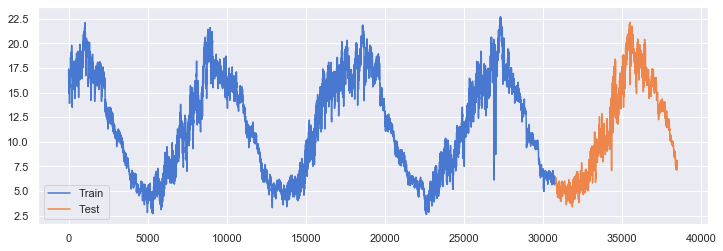

In [30]:
plt.plot(train, label='Train')
plt.plot([None for i in train] + [x for x in test], label='Test')
plt.legend()
plt.show()

## Walk forward validation
In order find the optimal number of past time steps we should use to forecast the subsqeunt one, we will use a technique known as walk-forward validation which is the equivalent of cross-validation for time series data. The process is as follows:

* Fit the model to the data $y_1\,, \ldots \,, yt$ and let $\hat{y}_{t+1}$ be the forecast of the next observation. 
* Compute the error $e_{t+1} = y_{t+1}-\hat{y}_{t+1}$ for the forecast observation.
* Repeat step 1 for $t=m\,, \ldots \,, n-1$ where $m$ is the minimum number of observations needed for fitting the model.
* Compute the Mean Absolute Error (MAE) from $ e_{m+1}\,, \ldots \,, e_n$.

In [31]:
persistence_values = range(1, train_size + 1)
scores = []

for p in persistence_values:
    # walk-forward validation
    history = [x for x in train]
    forecasts = []
    for i in range(len(test)):
        # make forecast
        yhat = history[-p]
        forecasts.append(yhat)
        # make observation
        history.append(test[i])
    # calculate MAE
    mae = mean_absolute_error(test, forecasts)
    scores.append(mae)

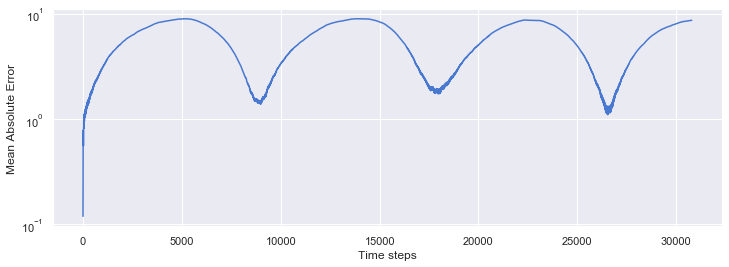

In [32]:
# plot scores over persistence values
plt.plot(persistence_values, scores)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Time steps')
plt.yscale('log')
plt.show()

From the above plot it appears the the smallest MSE occurs for a small number of past time steps. Let's find out exactly:

In [33]:
# find step size that gives min MSE
min(zip(list(persistence_values), scores), key = lambda t: t[1])

(1, 0.11823330735255912)

So the best "naive" forecast occurs when we use observations from the previous hour to forecast the subsequent one.

## Persistence forecasts

Next let's use the shift operator in pandas to create a new column with the naive prediction:

In [34]:
naive_prediction = ts.shift(1, freq=datetime.timedelta(hours=1))
naive_prediction.columns = ['naive_prediction']

As a sanity check, let's see that the predictions really do occur one week ahead from our original data:

In [44]:
ts.head()

temperature
date                            
2009-07-08 19:00:00         17.4
2009-07-08 20:00:00         17.4
2009-07-08 21:00:00         17.3
2009-07-08 22:00:00         17.1
2009-07-08 23:00:00         16.9

In [45]:
naive_prediction.head()

naive_prediction
date                                 
2009-07-08 20:00:00              17.4
2009-07-08 21:00:00              17.4
2009-07-08 22:00:00              17.3
2009-07-08 23:00:00              17.1
2009-07-09 00:00:00              16.9

Good, so the predictions occur where we expect them to. Next let's join the predictions back onto our original time series DataFrame:

In [46]:
naive_df = ts.merge(naive_prediction, how="outer", left_index=True, right_index=True)

In [47]:
naive_df.head()

temperature  naive_prediction
date                                              
2009-07-08 19:00:00         17.4               NaN
2009-07-08 20:00:00         17.4              17.4
2009-07-08 21:00:00         17.3              17.4
2009-07-08 22:00:00         17.1              17.3
2009-07-08 23:00:00         16.9              17.1

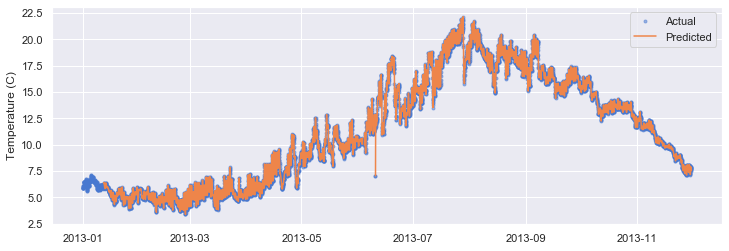

In [54]:
plt.plot(naive_df['2013':]['temperature'], label='Actual', marker='.', alpha=0.5, linestyle='None')
plt.plot(naive_df.iloc[train_size:,:]['naive_prediction'], label='Predicted')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()

As we can see, the predictions from the naive model are not too bad at all! The main drawback with these models is that one cannot produce reliable long term predictions. For that we need something more sophisticated ...